In [1]:
import os
def makedir(folder_path):
    # 检查文件夹是否已经存在
    if not os.path.exists(folder_path):
        # 文件夹不存在时创建
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 已创建")
    else:
        print(f"文件夹 '{folder_path}' 已存在，不进行任何处理")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
import numpy as np
import scanpy as sc
import math
import time

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [5]:
'''读取背景网络'''
def openPPI(filename):
    '''
        打开PPI
        文件格式 gene1_name gene1_id gene2_name gene2_id
        返回值：网络[节点是gene name]
    '''
    G = nx.Graph()
    a=open(filename,"r")
    next(a)

    for i in a:
        n=i.strip().split("\t")
        G.add_edge(n[0],n[3])
        G.add_node(n[0])
        G.add_node(n[3])
    a.close()
    return G

G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")

In [6]:
# 计算最大连通分支
def Lcc(G,genename):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,genename)
    if len(genename)==0:
        largest = 0
        l = []
        return l,largest
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = genename[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
        return list(l),largest

In [7]:
## 计算一组基因集合的表达值均值
def expressValue(genelist,annData_df,cell):
    '''
    :param genelist: 要计算的gene列表
    :param annData_df: 单细胞表达数据的df
    :param cell:  第几个细胞
    :return:
    '''

    # cell_expressedvalue = annData_df.loc[annData_df.index[cell],genelist]
    cell_expressedvalue = annData_df.loc[cell,genelist]
    if len(cell_expressedvalue)==0:
        return 0,0
    else:
        return sum(cell_expressedvalue), sum(cell_expressedvalue)/len(cell_expressedvalue)

In [8]:
# 计算最大连通分支，并返回最大连通分支上的基因表达值之和、均值
def lccExpressedValue(G,genename,annData_df,cell):
    '''
    :param g: 选定的背景网络
    :param genename:
    :param annData_df:
    :param cell:
    :return:
    '''

    lccgenelist, largest = Lcc(G,genename)
    lcc_expresssum,lcc_expressmean = expressValue(lccgenelist,annData_df,cell)
    return lcc_expresssum,lcc_expressmean

In [9]:
def LccExpress_mean(g,genelist,ran,annData_df,cell):
    '''
    每次从网络G的所有基因中随机选择genelist数量的gene，计算均值和标准差
    g:背景网络
    genelist：
    ran：随机次数
    返回：表达值之和、表达值均值的多次随机的均值和标准差
    '''

    all_genes = g.nodes()  # 背景网络中的gene

    #做随机实验
    l_list = []         #lcc列表
    l1_list = []         #lcc列表
    l2_list = []         #lcc列表
    for j in range(ran):
        black_nodes = random.sample(all_genes,len(genelist))
        l,largest_ran = Lcc(g,black_nodes)
        lcc_expresssum,lcc_expressmean = lccExpressedValue(g,black_nodes,annData_df,cell)

        l_list.append(largest_ran)
        l1_list.append(lcc_expresssum)
        l2_list.append(lcc_expressmean)

    #计算lcczscore
    lcc_mean = np.mean(l_list)
    lcc_std  = np.std(l_list)

    lcc1_mean = np.mean(l1_list)
    lcc1_std  = np.std(l1_list)

    lcc2_mean = np.mean(l2_list)
    lcc2_std  = np.std(l2_list)

    return lcc_mean,lcc_std,lcc1_mean,lcc1_std,lcc2_mean,lcc2_std

In [10]:
# 计算lcczscore
def lccZscore(Lcc,lcc_mean,lcc_std):
    if lcc_std == 0:
        zscore = 0
    else:
        zscore = (Lcc - lcc_mean)/lcc_std
        zscore = round(zscore,6)
    return zscore


In [11]:
# 计算某一组基因集合的lccexpresszscore
# G：整个背景网络
# g：随机选择基因集合的背景
def gensetLccExpressZscore(G,g,genelist,ran,annData_df,cell):
    l,lcc = Lcc(G,genelist)
    lcc_expresssum,lcc_expressmean = lccExpressedValue(G,genelist,annData_df,cell)
    lcc_mean,lcc_std,lcc_expresssum_mean,lcc_expresssum_std,lcc_expressmean_mean,lcc_expressmean_std = \
        LccExpress_mean(g,genelist,ran,annData_df,cell)

    lcc_zscore = lccZscore(lcc,lcc_mean,lcc_std)
    lcc_expresssum_zscore = lccZscore(lcc_expresssum,lcc_expresssum_mean,lcc_expresssum_std)
    lcc_expressmean_zscore = lccZscore(lcc_expressmean,lcc_expressmean_mean,lcc_expressmean_mean)

    return lcc_zscore,lcc_expresssum_zscore,lcc_expressmean_zscore

In [22]:
t = 28
for removal_ratio in range(1,5)[0:1]:  # 设定要删除的比例     
    G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")
    # 计算要删除的边数
    num_edges_to_remove = int(len(G.edges()) * removal_ratio*0.1)               
    # 随机选择要删除的边
    edges_to_remove = random.sample(list(G.edges()), num_edges_to_remove)                
    # 从图中删除这些边
    G.remove_edges_from(edges_to_remove)
        
    # 读取asthma gwas数据中所有基因
    trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\%s_new.txt"%(t+1),sep = "\t")
    trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
    trait_core = trait[trait["gene name"].isin(trait_coregene)]
    
    tissuelist = os.listdir(r"E:\00_CeSOP\results\asthma\lcczscore-pip-cell-sixpoints")
    for tissue in tissuelist[1:2]:
        print("//n%s"%tissue)
        # 读取TS FACS单细胞数据
        filePath = r"E:\00_CeSOP\data\TS_FACS\TS_%s.h5ad"%tissue
        annData = sc.read_h5ad(filePath)
        # 按照细胞类型进行分组,使用value_counts()方法计算每个分组中的细胞数量 ,按细胞数量逆序排列分组
        sorted_groups = pd.DataFrame(annData.obs)["cell_ontology_class"].value_counts().sort_values()
        celltypelist = list(sorted_groups.keys())

        ## 分别计算核心和外围
        genelist = trait_coregene

        # 创建结果文件夹
        makedir(r"E:\00_CeSOP\results\robust\network percent\percent%s\%s"%(100-removal_ratio*10,tissue))
        # 细胞类型
        num = 0
        for celltype in celltypelist:
            num +=1
            # 取出 'cd4-positive alpha-beta t cell' 对应的组的数据
            subset_annData = annData[annData.obs['cell_ontology_class'] == celltype, :]
            subset_annData_df = subset_annData.to_df()
            # 有表达的基因
            expressedGenes = subset_annData_df.apply(lambda row: subset_annData_df.columns[row.to_numpy().nonzero()[0]].tolist(), axis=1)
            celllist = list(expressedGenes.index)
            print(celltype,"细胞类型："+str(num)+"//"+str(len(celltypelist))+",细胞数量："+str(len(celllist)),str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

            # 计算每个细胞中的结果
            count = 0
            result_list = []
            for cell in celllist:   #cell是细胞名字
                count+=1

                # 单细胞有表达的网络基因
                singlecell_network_genelist = list(set(expressedGenes[cell]) & set(list(G.nodes())))
                
                # 构建单细胞子网络
                g = nx.subgraph(G,singlecell_network_genelist)
                core_scnet_genelist = list(set(genelist) & set(singlecell_network_genelist))
                l,lcc = Lcc(G,core_scnet_genelist)
               
                # lcc_expresszscore
                lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore = \
                    gensetLccExpressZscore(G,g,core_scnet_genelist,20,subset_annData_df,cell)  # 随机50次
                result_list.append([cell,len(core_scnet_genelist),lcc,lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore])

            df_singcell = pd.DataFrame(result_list)
            df_singcell.columns = ["cell","genenum","lcc","lcczscore","lcc_expresssum_zscore","lcc_expressmean_zscore"]
            df_singcell.to_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\%s\%s.csv"%(100-removal_ratio*10,tissue,celltype))



//nBlood
文件夹 'E:\00_CeSOP\results\robust\network percent\percent90\Blood' 已存在，不进行任何处理
granulocyte 细胞类型：1//27,细胞数量：2 2024-12-01 12:09:50
myeloid progenitor 细胞类型：2//27,细胞数量：3 2024-12-01 12:09:51
cd24 neutrophil 细胞类型：3//27,细胞数量：3 2024-12-01 12:09:51
non-classical monocyte 细胞类型：4//27,细胞数量：8 2024-12-01 12:09:52
plasmablast 细胞类型：5//27,细胞数量：10 2024-12-01 12:09:53
plasmacytoid dendritic cell 细胞类型：6//27,细胞数量：11 2024-12-01 12:09:56
cd141-positive myeloid dendritic cell 细胞类型：7//27,细胞数量：15 2024-12-01 12:09:58
nampt neutrophil 细胞类型：8//27,细胞数量：21 2024-12-01 12:10:01
basophil 细胞类型：9//27,细胞数量：29 2024-12-01 12:10:02
t cell 细胞类型：10//27,细胞数量：31 2024-12-01 12:10:09
hematopoietic stem cell 细胞类型：11//27,细胞数量：70 2024-12-01 12:10:15
platelet 细胞类型：12//27,细胞数量：239 2024-12-01 12:10:29
naive thymus-derived cd4-positive, alpha-beta t cell 细胞类型：13//27,细胞数量：412 2024-12-01 12:10:48
plasma cell 细胞类型：14//27,细胞数量：488 2024-12-01 12:11:45
macrophage 细胞类型：15//27,细胞数量：488 2024-12-01 12:13:07
type i nk t cell 细胞类型：16//27,细胞数量

In [3]:

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    else:
        return intersection / union

In [4]:
# 遍历文件夹中的指定格式的文件
def openFolderAll(folder_path,desired_extension):
    filelist = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(desired_extension):
            filelist.append(file_path)
    return filelist

In [15]:
for per in range(60,70,10): 
    tissuelist = os.listdir(r"E:\00_CeSOP\results\robust\network percent\percent%s"%per)
    for trait in range(29,30):  
        results_ct = pd.DataFrame()
        for tissue in tissuelist:
            folder_path = r"E:\00_CeSOP\results\robust\network percent\percent%s\%s"%(per,tissue)
            # print(folder_path)
            celltypelist = openFolderAll(folder_path,".csv")
    
            tissue_df = pd.DataFrame()
            for ct in celltypelist:
                celltype = ct.split("\\")[-1].split(".")[0]
                df = pd.read_csv(ct)
                df["celltype"] = celltype
                tissue_df = tissue_df.append(df)
            tissue_df["tissue"] = tissue
            results_ct = results_ct.append(tissue_df)
        results_ct.to_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\allcells.csv"%per)
        print(trait,"finish!")

29 finish!


In [6]:

tissuelist = os.listdir(r"E:\00_CeSOP\results\robust\network percent\percent60")
for trait in range(29,30):  
    results_ct = pd.DataFrame()
    for tissue in tissuelist:
        folder_path = r"E:\00_CeSOP\results\robust\network percent\percent60\%s"%(tissue)
        # print(folder_path)
        celltypelist = openFolderAll(folder_path,".csv")

        tissue_df = pd.DataFrame()
        for ct in celltypelist:
            celltype = ct.split("\\")[-1].split(".")[0]
            df = pd.read_csv(ct)
            df["celltype"] = celltype
            tissue_df = tissue_df.append(df)
        tissue_df["tissue"] = tissue
        results_ct = results_ct.append(tissue_df)
    results_ct.to_csv(r"E:\00_CeSOP\results\robust\network percent\percent60\allcells.csv")
    print(trait,"finish!")

NameError: name 'openFolderAll' is not defined

In [7]:
def get_subdirectories(path):
    return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

# 示例：读取当前目录下的所有文件夹名称
tissuelist = get_subdirectories(r"E:\00_CeSOP\results\robust\network percent\percent90")
tissuelist

['Bladder',
 'Blood',
 'Bone_Marrow',
 'Eye',
 'Fat',
 'Heart',
 'Kidney',
 'Large_Intestine',
 'Liver',
 'Lung',
 'Lymph_Node',
 'Mammary',
 'Muscle',
 'Pancreas',
 'Prostate',
 'Salivary_Gland',
 'Skin',
 'Small_Intestine',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea',
 'Uterus',
 'Vasculature']

In [8]:
## 

# 计算超几何分布pvalue
from scipy.stats import hypergeom
# Fisher's 精确检验
import numpy as np
from scipy.stats import fisher_exact

# core = "peri"
core = "core"
index = "lcczscore"
trait = 29
# index = "lcc_expresssum_zscore"
# index = "lcc_expressmean_zscore"
for percent in range(10,70,10):
    # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\allcells.csv"%(percent))
    results_ct_sorted = results_ct.sort_values(by=index,ascending=False)
    results_ct_sorted_topk = results_ct_sorted.iloc[:int(len(results_ct_sorted) * (10 / 100))][[index,"tissue","celltype","cell"]]
    
    #  计算超几何分布pvalue
    topkcells = set(list(results_ct_sorted_topk["cell"]))
    tissuelist = get_subdirectories(r"E:\00_CeSOP\results\robust\network percent\percent90")
    result_index = []
    for tissue in tissuelist:
        tissue_cell = results_ct[results_ct['tissue']==tissue]
        tissue_cell_topk = results_ct_sorted_topk[results_ct_sorted_topk['tissue']==tissue]
        tissue_cellnum = len(tissue_cell)
        tissue_cellnum_topk = len(tissue_cell_topk)
    
        # 计算jaccard系数
        jaccard = jaccard_similarity(set(tissue_cell["cell"]),set(tissue_cell_topk["cell"]))
    
        # 计算fisher精确检验pvalue
        b = tissue_cellnum
        a = tissue_cellnum_topk
        observed_table = [[a, b-a], [np.floor(b/10), b - np.floor(b/10)]]  # 2x2 列联表数据
        odds_ratio, p_value = fisher_exact(observed_table, alternative='greater')
    
        # 所有细胞M中与性状相关的细胞有N个，那么某个组织的n个细胞中有k个性状相关细胞是否显著高
        M = len(results_ct_sorted)
        N = len(results_ct_sorted_topk)
        n = tissue_cellnum
        k = tissue_cellnum_topk
        Hpvalue = hypergeom.sf(k-1,M,N,n)
    
        result_index.append([tissue,tissue_cellnum,tissue_cellnum_topk,
                       jaccard,p_value,Hpvalue])
    
    result_index_df = pd.DataFrame(result_index)
    result_index_df.columns = ["tissue","cellnum","relatedCellnum","jaccard","fisher's pvalue","hypergeom pvalue"]
    result_index_df.to_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)


In [10]:
result = pd.DataFrame()
for percent in range(10,100,10):
    print(percent)
    fisher_df  = pd.DataFrame()
    for ran in range(100):
        df = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\percent%s\top10_trait29_core_ran%s_lcczscore.csv"%(percent,ran))
        fisher_df = pd.concat([fisher_df,df["fisher's pvalue"]],axis=1)

    df = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\percent%s\top10_trait29_core_ran0_lcczscore.csv"%percent)    
    fisher_df.columns = [f"Ran{i}" for i in range(100)]
    fisher_df.index = df["tissue"]

    # 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
    fisher_df_01 = (fisher_df < 0.005).astype(int)    
    # 计算每行的和
    row_sums = fisher_df_01.sum(axis=1)    
    # 创建新列，当行和大于50时，将该列的值设置为1【表示显著】，否则为0
    fisher_df_01['New_Column'] = row_sums.apply(lambda x: 1 if x > 50 else 0)
    result = pd.concat([result,fisher_df_01['New_Column']],axis=1)

data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
# 使用 apply 来修改值
data["fisher's pvalue new"] = data["fisher's pvalue"].apply(lambda x: 1 if x < 0.005 else 0)
data.index = data["tissue"]
result = pd.concat([result,data["fisher's pvalue new"]],axis=1)   
result.columns = [f"Percent{i}" for i in range(10, 101, 10)]
result.to_csv(r"E:\00_CeSOP\results\robust\network percent\all.csv")

10
20
30
40
50
60
70
80
90


In [38]:
# result = pd.DataFrame()
# for percent in [70,80,90]:
#     # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
#     results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)
#     
#     result = pd.concat([result,results_ct["fisher's pvalue"]],axis=1)
# results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent90\tissue_top10_trait29_core_lcczscore.csv")    
# # result.columns =   [f"Percent{i}" for i in range(70,100,10)] 
# result.index = results_ct["tissue"]
# # 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
# fisher_df_01 = (result < 0.005).astype(int) 

In [39]:
result

,fisher's pvalue,fisher's pvalue,fisher's pvalue
tissue,,,
Bladder,5.030000e-28,1.000000e+00,9.858694e-01
Blood,1.000000e+00,1.000000e+00,1.000000e+00
Bone_Marrow,1.000000e+00,1.421889e-02,9.995585e-01
Eye,5.520000e-162,1.020000e-36,1.360000e-65
Fat,3.150000e-28,9.860000e-182,2.990000e-101
Heart,1.000000e+00,1.800000e-20,1.000000e+00
Kidney,1.000000e+00,1.000000e+00,1.000000e+00
Large_Intestine,1.000000e+00,1.000000e+00,1.000000e+00
Liver,7.517140e-02,1.000000e+00,9.992271e-01


<AxesSubplot: ylabel='tissue'>

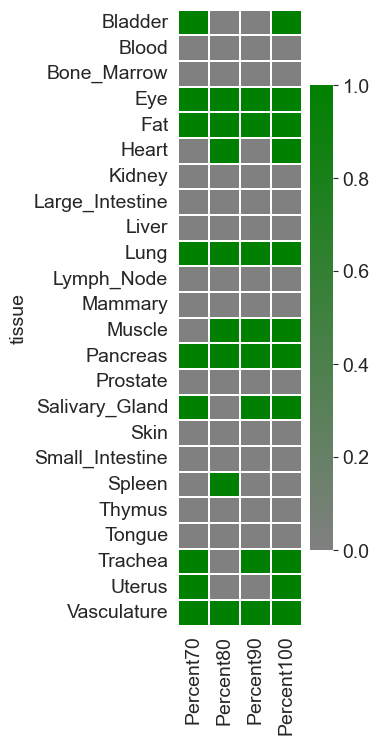

In [40]:
result = pd.DataFrame()
for percent in [70,80,90]:
    # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)
    
    result = pd.concat([result,results_ct["fisher's pvalue"]],axis=1)
results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent90\tissue_top10_trait29_core_lcczscore.csv")    
# result.columns =   [f"Percent{i}" for i in range(70,100,10)] 
result.index = results_ct["tissue"]
# 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
fisher_df_01 = (result < 0.005).astype(int)  

data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
# 使用 apply 来修改值
data["fisher's pvalue new"] = data["fisher's pvalue"].apply(lambda x: 1 if x < 0.005 else 0)
data.index = data["tissue"]
fisher_df_01 = pd.concat([fisher_df_01,data["fisher's pvalue new"]],axis=1)   
fisher_df_01.columns = [f"Percent{i}" for i in range(70, 101, 10)]

# 使用 seaborn 绘制热图
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# 创建灰色到绿色的自定义颜色映射
colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
cmap = LinearSegmentedColormap.from_list("gray_green", colors)
plt.figure(figsize=(2, 8))  # 设置图形大小
sns.heatmap(fisher_df_01, cmap=cmap,linewidths = 0.05)

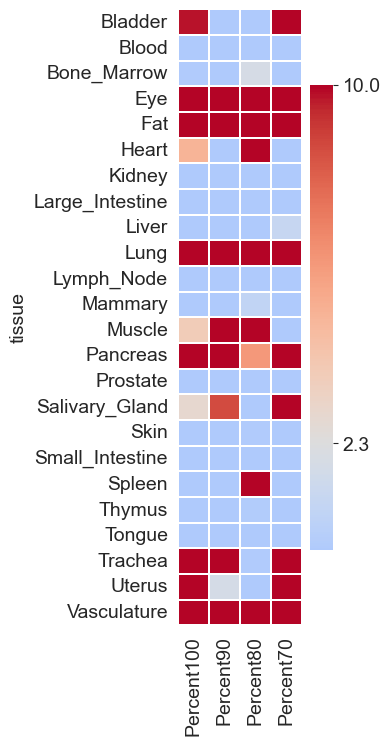

In [19]:
result = pd.DataFrame()
for percent in [70,80,90]:
    # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)
    
    result = pd.concat([result,results_ct["fisher's pvalue"]],axis=1)
results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent90\tissue_top10_trait29_core_lcczscore.csv")    
# result.columns =   [f"Percent{i}" for i in range(70,100,10)] 
result.index = results_ct["tissue"]


data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
data.index = data["tissue"]
fisher_df_01 = pd.concat([result,data["fisher's pvalue"]],axis=1)   
fisher_df_01.columns = [f"Percent{i}" for i in range(70, 101, 10)]

# 使用 seaborn 绘制热图
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# 创建灰色到绿色的自定义颜色映射
# colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
# cmap = LinearSegmentedColormap.from_list("gray_green", colors)
# plt.figure(figsize=(2, 8))  # 设置图形大小
# sns.heatmap(fisher_df_01, cmap=cmap,linewidths = 0.05)

epsilon = 1e-10
# result = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\all.csv",index_col=0)
result_log = -np.log10(fisher_df_01+epsilon)
plt.rcParams['font.size'] = 14
plt.figure(figsize=(2, 8))  # 设置图形大小
x = -np.log10(0.005 + epsilon)
g = sns.heatmap(result_log[result_log.columns[::-1]], cmap='coolwarm', linewidths = 0.05, 
                center = x,
                # alpha = 0.8,
                cbar_kws={
                # 'orientation': 'horizontal',  # 色条的方向为水平
                'shrink': 1,                # 色条缩小为 80%
                'aspect': 20,                 # 色条的长宽比
                # 'label': 'Value',             # 色条标签
                'ticks': [math.floor(result_log.values.min()), x, math.ceil(result_log.values.max())]           # 设置色条的刻度
            }
                )

<Figure size 400x100 with 0 Axes>

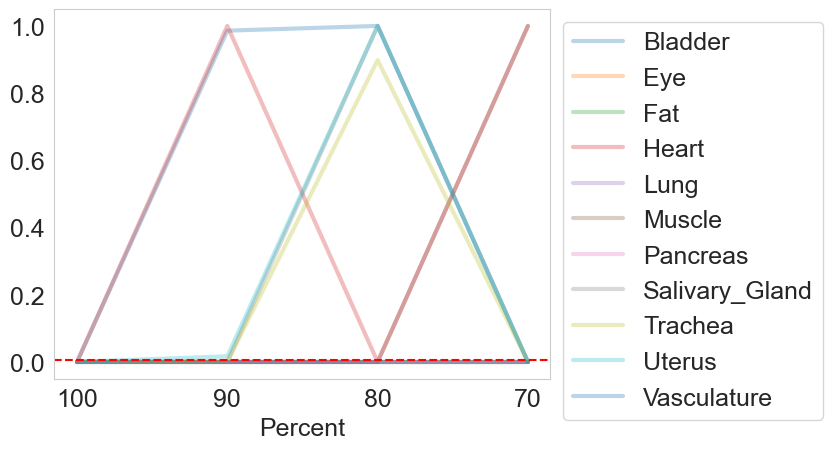

In [10]:
result = pd.DataFrame()
for percent in [70,80,90]:
    # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)
    
    result = pd.concat([result,results_ct["fisher's pvalue"]],axis=1)
results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent90\tissue_top10_trait29_core_lcczscore.csv")    
# result.columns =   [f"Percent{i}" for i in range(70,100,10)] 
result.index = results_ct["tissue"]


data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
data.index = data["tissue"]
# 筛选 col1 列值小于 0.005 的行
filtered_list = list(data[data["fisher's pvalue"] < 0.005]["tissue"])
fisher_df_01 = pd.concat([result,data["fisher's pvalue"]],axis=1)   
# fisher_df_01.columns = [f"Percent{i}" for i in range(70, 101, 10)]
result_filtered_df = fisher_df_01[fisher_df_01.index.isin(filtered_list)]
result_filtered_df.columns = [f"{i}" for i in range(70, 101, 10)]

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 18
plt.figure(figsize=(4, 1))
ax = result_filtered_df[result_filtered_df.columns[::-1]].T.plot(linestyle='-', linewidth=3,alpha=0.3,ylabel="",xlabel = "Percent")
plt.grid(False)
# 显示图形
# 设置图例在图表外部
# 添加横线
plt.axhline(y=0.005, color='red', linestyle='--')

# 添加竖线
# plt.axvline(x=4, color='blue', linestyle='--')

# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [9]:
result_filtered_df

,70,80,90,100
tissue,,,,
Bladder,5.030000e-28,1.000000e+00,9.858694e-01,5.913325e-11
Eye,5.520000e-162,1.020000e-36,1.360000e-65,1.830254e-113
Fat,3.150000e-28,9.860000e-182,2.990000e-101,2.163322e-147
Heart,1.000000e+00,1.800000e-20,1.000000e+00,8.566823e-06
Lung,0.000000e+00,7.080000e-80,5.990000e-202,7.135368e-122
Muscle,9.998356e-01,5.180000e-90,9.220000e-23,1.589517e-04
Pancreas,2.270000e-64,6.410000e-07,1.150000e-18,1.238276e-13
Salivary_Gland,1.940000e-63,1.000000e+00,2.440000e-09,1.318937e-03
Trachea,7.640000e-37,8.982181e-01,1.580000e-29,4.040684e-27


In [18]:
result

,fisher's pvalue,fisher's pvalue,fisher's pvalue,fisher's pvalue,fisher's pvalue,fisher's pvalue,fisher's pvalue,fisher's pvalue,fisher's pvalue
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.030000e-28,1.000000e+00,9.858694e-01
1,1.000000e+00,9.999854e-01,1.000000e+00,1.000000e+00,3.183057e-13,9.967394e-01,1.000000e+00,1.000000e+00,1.000000e+00
2,1.000000e+00,6.928594e-38,4.613155e-139,5.700444e-171,4.496237e-221,4.368206e-127,1.000000e+00,1.421889e-02,9.995585e-01
3,1.000000e+00,8.660738e-29,4.961766e-48,3.330764e-78,1.064113e-61,6.051847e-93,5.520000e-162,1.020000e-36,1.360000e-65
4,9.994187e-01,1.000000e+00,3.986205e-03,9.999984e-01,5.909506e-85,3.663832e-01,3.150000e-28,9.860000e-182,2.990000e-101
5,9.110816e-38,2.752919e-20,1.154446e-33,9.893762e-01,1.324372e-191,4.983256e-07,1.000000e+00,1.800000e-20,1.000000e+00
6,3.862336e-09,1.000000e+00,2.491506e-01,1.000000e+00,1.153163e-32,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
7,9.999996e-01,9.998442e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
8,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.517140e-02,1.000000e+00,9.992271e-01
9,9.999651e-01,7.704150e-01,4.046639e-04,5.957005e-03,4.868503e-05,9.999592e-01,0.000000e+00,7.080000e-80,5.990000e-202


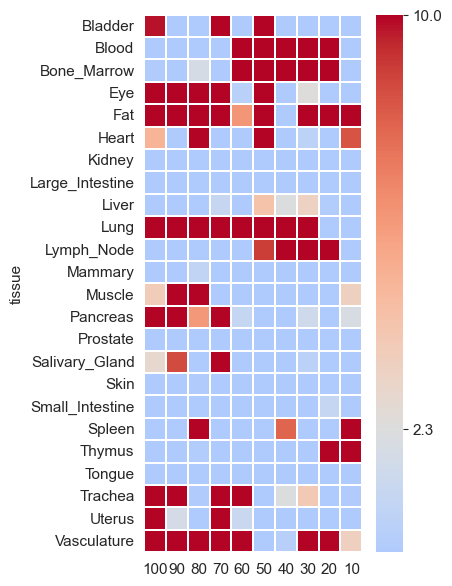

In [38]:
import pandas as pd

result = pd.DataFrame()
for percent in range(10,100,10):
    # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)
    
    result = pd.concat([result,results_ct["fisher's pvalue"]],axis=1)
results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent90\tissue_top10_trait29_core_lcczscore.csv")    
# result.columns =   [f"Percent{i}" for i in range(70,100,10)] 
result.index = results_ct["tissue"]


data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
data.index = data["tissue"]
fisher_df_01 = pd.concat([result,data["fisher's pvalue"]],axis=1)   
# fisher_df_01.columns = [f"Percent{i}" for i in range(10, 101, 10)]
fisher_df_01.columns = [f"{i}" for i in range(10, 101, 10)]

# 使用 seaborn 绘制热图
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# 创建灰色到绿色的自定义颜色映射
# colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
# cmap = LinearSegmentedColormap.from_list("gray_green", colors)
# plt.figure(figsize=(2, 8))  # 设置图形大小
# sns.heatmap(fisher_df_01, cmap=cmap,linewidths = 0.05)

epsilon = 1e-10
result = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\all.csv",index_col=0)

result_log = -np.log10(fisher_df_01+epsilon)

plt.rcParams['font.size'] = 11
plt.figure(figsize=(4.5, 6))  # 设置图形大小
x = -np.log10(0.005 + epsilon)
g = sns.heatmap(result_log[result_log.columns[::-1]], cmap='coolwarm', linewidths = 0.05, 
                center = x,
                # alpha = 0.8,
                cbar_kws={
                # 'orientation': 'horizontal',  # 色条的方向为水平
                'shrink': 1,                # 色条缩小为 80%
                'aspect': 20,                 # 色条的长宽比
                # 'label': 'Value',             # 色条标签
                'ticks': [math.floor(result_log.values.min()), x, math.ceil(result_log.values.max())]           # 设置色条的刻度
            }
                )
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\robust\network_percent.png")
plt.show()


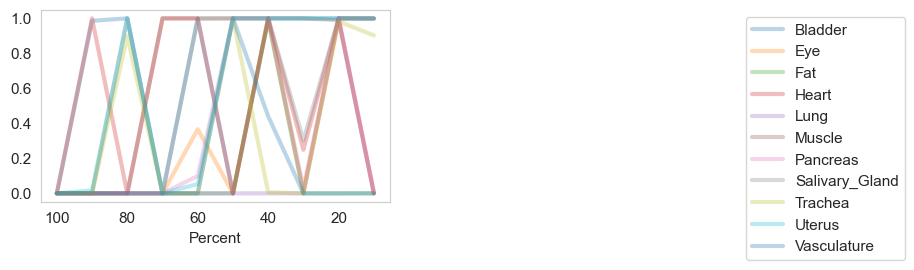

In [35]:
result = pd.DataFrame()
for percent in range(10,100,10):
    # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)
    
    result = pd.concat([result,results_ct["fisher's pvalue"]],axis=1)
results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent90\tissue_top10_trait29_core_lcczscore.csv")    
# result.columns =   [f"Percent{i}" for i in range(70,100,10)] 
result.index = results_ct["tissue"]


data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
data.index = data["tissue"]
# 筛选 col1 列值小于 0.005 的行
filtered_list = list(data[data["fisher's pvalue"] < 0.005]["tissue"])
fisher_df_01 = pd.concat([result,data["fisher's pvalue"]],axis=1)   
# fisher_df_01.columns = [f"Percent{i}" for i in range(70, 101, 10)]
result_filtered_df = fisher_df_01[fisher_df_01.index.isin(filtered_list)]
result_filtered_df.columns = [f"{i}" for i in range(10, 101, 10)]

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 11
# plt.figure(figsize=(4, 1))
# plt.plot(result_filtered_df[result_filtered_df.columns[::-1]].T,linestyle='-', linewidth=3,alpha=0.3,ylabel="",xlabel = "Percent",)
ax = result_filtered_df[result_filtered_df.columns[::-1]].T.plot(linestyle='-', linewidth=3,alpha=0.3,ylabel="p",xlabel = "Percent",figsize=(4.5, 2.5))
plt.grid(False)
# 显示图形
# 设置图例在图表外部
# 添加横线
# plt.axhline(y=0.005, color='red', linestyle='--')
# 添加竖线
# plt.axvline(x=4, color='blue', linestyle='--')

# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(2, 1))
# plt.legend()

plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\robust\network_percent_zhexian.png")
plt.show()

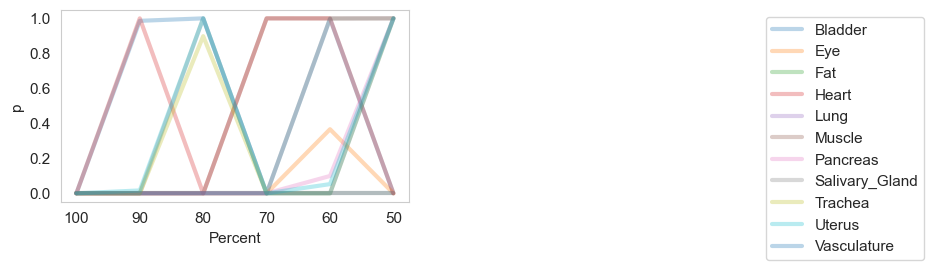

In [37]:
result = pd.DataFrame()
for percent in range(50,100,10):
    # makedir(r"E:\00_CeSOP\results\robust\network percent\tissue")
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent%s\tissue_top10_trait29_core_lcczscore.csv"%percent)
    
    result = pd.concat([result,results_ct["fisher's pvalue"]],axis=1)
results_ct = pd.read_csv(r"E:\00_CeSOP\results\robust\network percent\percent90\tissue_top10_trait29_core_lcczscore.csv")    
# result.columns =   [f"Percent{i}" for i in range(70,100,10)] 
result.index = results_ct["tissue"]


data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
data.index = data["tissue"]
# 筛选 col1 列值小于 0.005 的行
filtered_list = list(data[data["fisher's pvalue"] < 0.005]["tissue"])
fisher_df_01 = pd.concat([result,data["fisher's pvalue"]],axis=1)   
# fisher_df_01.columns = [f"Percent{i}" for i in range(70, 101, 10)]
result_filtered_df = fisher_df_01[fisher_df_01.index.isin(filtered_list)]
result_filtered_df.columns = [f"{i}" for i in range(50, 101, 10)]

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 11
# plt.figure(figsize=(4, 1))
# plt.plot(result_filtered_df[result_filtered_df.columns[::-1]].T,linestyle='-', linewidth=3,alpha=0.3,ylabel="",xlabel = "Percent",)
ax = result_filtered_df[result_filtered_df.columns[::-1]].T.plot(linestyle='-', linewidth=3,alpha=0.3,ylabel="p",xlabel = "Percent",figsize=(4.5, 2.5))
plt.grid(False)
# 显示图形
# 设置图例在图表外部
# 添加横线
# plt.axhline(y=0.005, color='red', linestyle='--')
# 添加竖线
# plt.axvline(x=4, color='blue', linestyle='--')

# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(2, 1))
# plt.legend()

plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\robust\network_percent_zhexian.png")
plt.show()